# Your own few-shot classification model ready in 15mn with PyTorch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sicara/tuto-fsl/blob/master/tuto.ipynb)

I have been working on few-shot classification for a while now,
and the more I talk about it, the more the people around me seem to feel
that it's some kind of dark magic, and I noticed that very few actually used
it on their projects. I think it's too bad, so I decided to make this tutorial
so you'll have no excuse to deprive yourself of the power of few-shot learning methods.

In 15 minutes and just a few lines of code, we are going to implement
the [Prototypical Networks](https://arxiv.org/abs/1703.05175). It's the favorite method of
many few-shot learning researchers (~2000 citations in 3 years), because 1) it works well,
and 2) it's incredibly easy to grasp and to implement.

## Discovering Prototypical Networks
First, let's clone the [tutorial GitHub repository](https://github.com/sicara/tuto-fsl) and import some packages.

In [1]:
!git clone https://github.com/sicara/tuto-fsl.git tuto_fsl

Cloning into 'tuto_fsl'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 28 (delta 7), reused 21 (delta 3), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from tqdm import tqdm

from tuto_fsl.src.dataset import EasySet
from tuto_fsl.src.sampler import TaskSampler
from tuto_fsl.src.utils import plot_images, sliding_average

Now, we need a dataset. I suggest we use [Caltech-UCSD Birds 200](http://www.vision.caltech.edu/visipedia/CUB-200.html), or *CUB*.
It's a dataset of 6,033 images of 200 different bird species. It's 647Mb so while it downloads, feel free
to scroll down and discover the code of the Prototypical Networks.

In [3]:
!mkdir data
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1GDr1OkoXdhaXWGA8S3MAq3a522Tak-nx' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1GDr1OkoXdhaXWGA8S3MAq3a522Tak-nx" -O data/images.tgz
!rm -rf /tmp/cookies.txt
!tar  --exclude='._*' -zxvf data/images.tgz -C data

Streaming output truncated to the last 5000 lines.
images/167.Hooded_Warbler/Hooded_Warbler_0024_2654633686.jpg
images/167.Hooded_Warbler/Hooded_Warbler_0025_2690306769.jpg
images/167.Hooded_Warbler/Hooded_Warbler_0026_2817738193.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0001_495149583.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0002_2471636465.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0003_2540117270.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0004_2301685839.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0005_498814033.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0006_2519317376.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0007_2468962218.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0008_2464457843.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0009_2591413864.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0010_2316599673.jpg
images/166.Golden_

Simply put, in a few-shot classification task, you have a labeled support set (which kind of acts
like a catalog) and query set. For each image of the query set, we want to predict a label from the
labels present in the support set. A few-shot classification model has to use the information from the
support set in order to classify query images. We say *few-shot* when the support set contains very
few images for each label (typically less than 10). The figure below shows a 3-way 2-shots classification task.
We expect a model that has never seen any Saint-Bernard, Pug or Labrador during its training to successfully
predict the query labels. The support set is the only information that the model has regarding what a Saint-Bernard,
a Pug or a Labrador can be.
![few-shot classification task](https://images.ctfassets.net/be04ylp8y0qc/bZhboqYXfYeW4I88xmMNv/7c5efdc368206feaad045c674b1ced95/1_AteD0yXLkQ1BbjQTB3Ytwg.png?fm=webp)

Most few-shot classification methods are *metric-based*. It works in two phases : 1) they use a CNN to project both
support and query images into a feature space, and 2) they classify query images by comparing them to support images.
If, in the feature space, an image is closer to pugs than it is to labradors and Saint-Bernards, we will guess that
it's a pug.

From there, we have two challenges :

1. Find the good feature space. This is what convolutional networks are for. A CNN is basically a function
that outputs a representation (or *embedding*)of any input in a given dimension. The challenge here is to have a CNN that will
project images of the same class into representations that are close to each other, even if it has not been trained
on objects of this class.
2. Find a good way to compare the representations in the feature space. This is the job of Prototypical Networks.


![Prototypical classification](https://images.ctfassets.net/be04ylp8y0qc/45M9UcUp6KnzwDaBHeGZb7/bb2dcda5942ee7320600125ac2310af6/0_M0GSRZri859fGo48.png?fm=webp)

From the support set, Prototypical Networks compute a prototype for each class, which is the mean of all embeddings
of support images from this class. Then, each query is simply classified as the nearest prototype in the feature space,
with respect to euclidean distance.

If you want to learn more about how this works, I explain it
[here](https://www.sicara.ai/blog/2019-07-30-image-classification-few-shot-meta-learning).
But by now, CUB should be up and ready, so let's get to coding.
Below, we simply define Prototypical Networks as a torch module, with a `forward()` method.
You may notice 2 things.

1. We initiate `PrototypicalNetworks` with a *backbone*. This is the feature extractor we were talking about.
Here, we use as backbone a ResNet18 pretrained on ImageNet, with its head chopped off and replaced by a `Flatten`
layer. The output of the backbone, for an input image, will be a 512-dimensional feature vector.
2. The forward method doesn't only take one input tensor, but 3: in order to predict the labels of query images,
we also need support images and labels as inputs of the model.

In [4]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
            self,
            support_images: torch.Tensor,
            support_labels: torch.Tensor,
            query_images: torch.Tensor
    ) -> torch.Tensor :
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now we have a model! Note that we used a pretrained feature extractor,
so our model should already be up and running. Let's see that.

Here we create a dataloader that will feed few-shot classification tasks to our model.
But a regular PyTorch dataloader will feed batches of images, with no consideration for
their label or whether they are support or query. We need 2 specific features in our case.

1. We need images evenly distributed between a given number of classes.
2. We need them split between support and query sets.

For the first point, I wrote a custom sampler: it first samples `n_way` classes from the dataset,
then it samples `n_shot + n_query` images for each class (for a total of `n_way * (n_shot + n_query)`
images in each batch).
For the second point, I have a custom collate function to replace the built-in PyTorch `collate_fn`.
This baby feed each batch as the combination of 5 items:

1. support images
2. support labels between 0 and `n_way`
3. query images
4. query labels between 0 and `n_way`
5. a mapping of each label in `range(n_way)` to its true class id in the dataset
(it's not used by the model but it's very useful for us to know what the true class is)

You can see that in PyTorch, a DataLoader is basically the combination of a sampler, a dataset and a collate function
(and some multiprocessing voodoo): sampler says which items to fetch, the dataset says how to fetch them, and
the collate function says how to present these items together. If you want to dive into these custom objects,
they're [here](https://github.com/sicara/tuto-fsl/tree/master/src).

In [5]:
N_WAY = 5
N_SHOT = 5
N_QUERY = 10
N_EVALUATION_TASKS = 100

test_set = EasySet("tuto_fsl/data/test.json")
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

We created a dataloader that will feed us with 5-way 5-shot tasks (the most common setting in the litterature).
Now, as every data scientist should do before launching opaque training scripts,
let's take a look at our dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


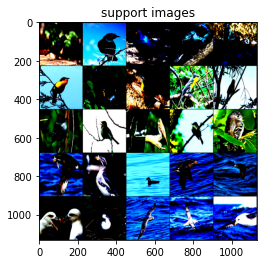

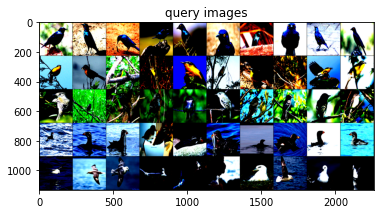

In [6]:
support_images, support_labels, query_images, query_labels, class_ids = next(
    iter(test_loader)
)

plot_images(support_images, "support images", images_per_row=N_SHOT)
plot_images(query_images, "query images", images_per_row=N_QUERY)

For both support and query set, you should have one line for each class.

How does our model perform?

In [7]:
model.eval()
scores = model(
    support_images.cuda(), support_labels.cuda(), query_images.cuda()
).detach()

_, predicted_labels = torch.max(scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(query_labels)):
    print(
        f"{test_set.class_names[class_ids[query_labels[i]]]} / {test_set.class_names[class_ids[predicted_labels[i]]]}"
    )

Ground Truth / Predicted
134.Cape_Glossy_Starling / 134.Cape_Glossy_Starling
134.Cape_Glossy_Starling / 134.Cape_Glossy_Starling
134.Cape_Glossy_Starling / 134.Cape_Glossy_Starling
134.Cape_Glossy_Starling / 134.Cape_Glossy_Starling
134.Cape_Glossy_Starling / 134.Cape_Glossy_Starling
134.Cape_Glossy_Starling / 134.Cape_Glossy_Starling
134.Cape_Glossy_Starling / 134.Cape_Glossy_Starling
134.Cape_Glossy_Starling / 134.Cape_Glossy_Starling
134.Cape_Glossy_Starling / 134.Cape_Glossy_Starling
134.Cape_Glossy_Starling / 134.Cape_Glossy_Starling
020.Yellow_breasted_Chat / 020.Yellow_breasted_Chat
020.Yellow_breasted_Chat / 020.Yellow_breasted_Chat
020.Yellow_breasted_Chat / 020.Yellow_breasted_Chat
020.Yellow_breasted_Chat / 020.Yellow_breasted_Chat
020.Yellow_breasted_Chat / 020.Yellow_breasted_Chat
020.Yellow_breasted_Chat / 020.Yellow_breasted_Chat
020.Yellow_breasted_Chat / 020.Yellow_breasted_Chat
020.Yellow_breasted_Chat / 020.Yellow_breasted_Chat
020.Yellow_breasted_Chat / 020.Yellow_b

This doesn't look bad: keep in mind that the model has only seen 5 examples for each class!
I don't know about you, but looking at the images above, I'm not sure I could always tell which is which.

Now that we have a first idea, let's see more precisely how good our model is.

In [8]:
def evaluate(
            support_images: torch.Tensor,
            support_labels: torch.Tensor,
            query_images: torch.Tensor,
            query_labels: torch.Tensor,
    ) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)

# We'll count everything and compute the ratio at the end
total_predictions = 0
correct_predictions = 0

# eval mode affects the behaviour of some layers (such as batch normalization or dropout)
# no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
model.eval()
with torch.no_grad():
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        class_ids,
    ) in tqdm(enumerate(test_loader), total=len(test_loader)):

        correct, total = evaluate(
            support_images, support_labels, query_images, query_labels
        )

        total_predictions += total
        correct_predictions += correct

print(
    f"Model tested on {len(test_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
)

100%|██████████| 100/100 [00:49<00:00,  2.01it/s]

Model tested on 100 tasks. Accuracy: 87.48%


If you didn't mess with anything, the result should be around 87%
(if not, raise an issue or something). This is not an incredible score for 5-way classification,
but then again: **only 5 examples per class**.

Now that you know how to make Prototypical Networks work, you can see what happens if you tweak it
a little bit (change the backbone, use other distances than euclidean...) or if you change the problem
(more classes in each task, less or more examples in the support set, maybe even one example only,
but keep in mind that in that case Prototypical Networks are just standard nearest neighbour).

When you're done, you can scroll further down and learn how to **meta-train this model**.

In [ ]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

train_set = EasySet("data/train.json")
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)
val_set = EasySet("data/val.json")
val_sampler = TaskSampler(val_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_VALIDATION_TASKS)
val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
        self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
_close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the a

In [ ]:
convolutional_network = resnet18(pretrained=False)
convolutional_network.fc = nn.Flatten()
model = PrototypicalNetworks(convolutional_network).cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def fit(support_images, support_labels, query_images, query_labels) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
val_frequency = 100
log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

        if (episode_index + 1) % val_frequency == 0:
            correct_predictions = 0
            total_predictions = 0
            with torch.no_grad():
                for (
                    val_support_images,
                    val_support_labels,
                    val_query_images,
                    val_query_labels,
                    _,
                ) in val_loader:

                    correct, total = evaluate(
                        val_support_images,
                        val_support_labels,
                        val_query_images,
                        val_query_labels,
                    )

                    total_predictions += total
                    correct_predictions += correct
                val_accuracy = correct_predictions / total_predictions
                print(
                    f"Validated on {len(val_loader)} tasks. Accuracy: {100 * val_accuracy:.2f}%"
                )

100%|██████████| 500/500 [02:22<00:00,  3.51it/s, loss=1.49]


Validated on 10 tasks. Accuracy: 28.00%
Validated on 10 tasks. Accuracy: 36.40%
Validated on 10 tasks. Accuracy: 35.20%
Validated on 10 tasks. Accuracy: 34.40%
Validated on 10 tasks. Accuracy: 34.00%
